In [1]:
import kelp_param
import kelp3d_objs as k3
import ipyparallel as ipp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipyvolume as ipv

In [2]:
remote_config = kelp_param.ParamSpanRemoteConfig()
ipp.Client().ids

[0]

In [7]:
# Hard-coded parameters
absorptance_kelp = 0 * 0.8 # (%)
rope_spacing = 5.0 # (m)
zmin, zmax = 0.0, 10.0 # (m)
nz=10

# Surface Irradiance
I0 = 50.0 # (W/m^2)
phi_s = 0 # (rad)
theta_s = 0 # (rad)
decay = 0 # (?) - light (practically) only from directly above

# Calculated or otherwise boring parameters
xmin = -rope_spacing/2
xmax = rope_spacing/2
ymin = -rope_spacing/2
ymax = rope_spacing/2

# Solver parameters
tol_abs = 1e-6
tol_rel = 1e-6
maxiter_inner = 50
maxiter_outer = 50
gmres_wrapper = k3.gmres_wrapper

const = (rope_spacing, zmin, zmax, nz, I0, phi_s, theta_s, decay, xmin, xmax, ymin, ymax, absorptance_kelp,
         tol_abs, tol_rel, maxiter_inner, maxiter_outer, gmres_wrapper)

In [8]:
psw = kelp_param.ParamSpanWidget(
    'kelp', 
    remote_config, 
    kelp_param.kelp_calculate, 
    kelp_param.kelp_visualize
)
psw.set_params(
    a_water = [0.1],
    b = [0.5, 0.1],#, 0.7],
    # Number of x & y grid cells
    ns = [10],#, 10, 12],
    # Number of angular grid cells (Same for theta & phi)
    na = [10],#, 10, 12],#, 14, 18, 20, 24],
    #na = [10, 12, 14, 18],
    gmres_flag = [True],
    num_scatters = [0],
    kelp_profile = ['top-heavy'],# 'bottom-heavy', 'uniform'],
    const=[const]
)
psw.submit_computations()
psw

ParamSpanWidget(children=(Output(layout=Layout(border='1px solid', height='500px', overflow_x='scroll', overfl…

# Compare Asymptotics to Finite Difference

In [9]:
# Set parameters
a_water = 0.0
b = 0.0
ns = 10
na = 10
kelp_profile='top-heavy'
max_scatter = 3

# GMRES
gmres_results = kelp_param.kelp_calculate(
    a_water,
    b,
    ns,
    na,
    kelp_profile,
    gmres_flag=True,
    num_scatters=0,
    const=const
)

res_list = []
save_list = []

p_kelp = gmres_results['p_kelp']
true_irrad = gmres_results['irradiance']
true_perceived_irrad = np.sum(p_kelp*true_irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1)) / np.pi

# Run scattering cases
for n in range(max_scatter+1):
    print("n={}".format(n))
    #print("const={}".format(const))
    compute_results = kelp_param.kelp_calculate(
        a_water,
        b,
        ns,
        na,
        kelp_profile,
        gmres_flag=False,
        num_scatters=n,
        const=const
    )

    irrad = compute_results['irradiance']
    # Perceived irradiance for each depth layer
    perceived_irrad = np.sum(p_kelp*irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
    err = np.abs(true_perceived_irrad - perceived_irrad)
    rad_err = np.mean(compute_results['radiance'] - gmres_results['radiance'])

    save_vals = {
        'abs_err': err,
        'rel_err': err / np.abs(true_perceived_irrad),
        'perceived_irrad': perceived_irrad,
        'irradiance': irrad,
        'abs_rad_err': rad_err,
        'rel_rad_err': rad_err / np.abs(gmres_results['radiance'])
    }

    res_list.append(compute_results)
    save_list.append(save_vals)

dz = 1.0
theoretical max_kelp = 0.1
Max kelp = 0.015742197254395126
GMRES Success!
n=0
dz = 1.0
theoretical max_kelp = 0.1
Max kelp = 0.015742197254395126
n=1
dz = 1.0
theoretical max_kelp = 0.1
Max kelp = 0.015742197254395126
n=2
dz = 1.0
theoretical max_kelp = 0.1
Max kelp = 0.015742197254395126


/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in true_divide


n=3
dz = 1.0
theoretical max_kelp = 0.1
Max kelp = 0.015742197254395126


# Plot Convergence Curves

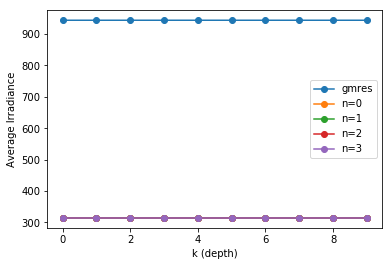

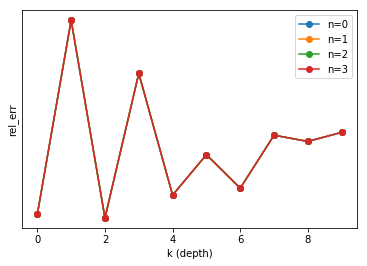

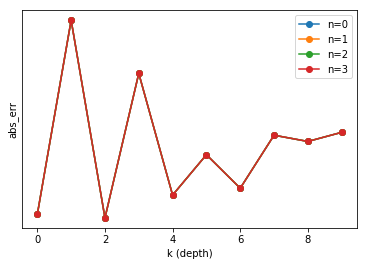

In [10]:
plt.figure()
plt.plot(gmres_results['irradiance'].mean(axis=(0,1)), 'o-', label='gmres')
for n, irrad in enumerate([s['irradiance'] for s in save_list]):
    plt.plot(irrad.mean(axis=(0,1)), 'o-', label='n={}'.format(n))
plt.yscale('linear')
plt.legend()
plt.xlabel('k (depth)')
plt.ylabel('Average Irradiance')

plt.figure()
for n, err in enumerate([s['rel_err'] for s in save_list]):
    plt.plot(err, 'o-', label='n={}'.format(n))
plt.yscale('log')
plt.legend()
plt.xlabel('k (depth)')
plt.ylabel('rel_err')

plt.figure()
for n, err in enumerate([s['abs_err'] for s in save_list]):
    plt.plot(err, 'o-', label='n={}'.format(n))
plt.yscale('log')
plt.legend()
plt.xlabel('k (depth)')
plt.ylabel('abs_err')

plt.show()

In [12]:
50 * 4*np.pi

628.3185307179587